<a href="https://colab.research.google.com/github/shivendr7/ml/blob/assignments/ImageSRwithourInterpolation_1(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [20]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Reshape, Flatten, Input, MaxPooling2D, Dense, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

In [40]:
bsize=2;a=28;b=28;c=tf.cast(64/4, tf.int32)
shape=tf.stack([bsize,a,b,2,2,c])

In [44]:
shape.get_shape(), shape

(TensorShape([6]),
 <tf.Tensor: shape=(6,), dtype=int32, numpy=array([ 2, 28, 28,  2,  2, 16], dtype=int32)>)

In [60]:
I=np.ones(shape=(100352,))
X=tf.reshape(tensor=I, shape=shape)
print(X.shape)
X=tf.transpose(X, (0,1,2,4,3,5))
print(X.shape)

(2, 28, 28, 2, 2, 16)
(2, 28, 28, 2, 2, 16)


In [61]:
X=tf.split(X, 28, axis=1)

In [65]:
type(X)

list

In [71]:
def _phase_shift(I, r):  # defines periodical shuffling to upscale image
    input_shape = tf.shape(I)
    bsize = input_shape[0]
    a = input_shape[1]
    b = input_shape[2]
    c = tf.cast(input_shape[3]/(r ** 2),tf.int32)
    shape = tf.stack([bsize,a,b,r,r,c])
 
    input_shape_as_numbers = I.get_shape()
 
    X = tf.reshape(tensor=I, shape=shape)
    X = tf.transpose(X, (0, 1, 2, 4, 3,5))  
    X = tf.split(X, input_shape_as_numbers[1], axis=1)  
    X = tf.concat([tf.squeeze(x) for x in X], axis=2)  
    X = tf.split(X,input_shape_as_numbers[2], axis=1) 
    X = tf.concat([tf.squeeze(x) for x in X], axis=2) 
 
    return tf.reshape(X, (bsize, a*r, b*r, c))
 
def PS(input_shape, r, name, color=False):
 
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
            input_shape[1] * r,
            input_shape[2] * r,
            int(input_shape[3] / (r ** 2))]
        output_shape = tuple(dims)
        return output_shape
  
    def subpixel(x):
        if color:
            Xc = tf.split(3, 3, X)
            X = tf.concat(3, [_phase_shift(x, r) for x in Xc])
        else:
            x_upsampled = _phase_shift(x, r)
        return x_upsampled
 
    return Lambda(subpixel, output_shape=subpixel_shape, name=name)
 
 
# encoder layers
encoder_inputs = Input(shape = (14,14,1))
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
#pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(conv1)
#pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
#flat = Flatten()(pool2)
conv3 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(conv2)
#decoder layer
#dense_layer_d = Dense(7*7*32, activation = 'relu')(flat)
#output_from_d = Reshape((7,7,32))(dense_layer_d)
conv4 = Conv2D(4, (3,3), activation = 'relu', padding = "SAME")(conv3)
# convolution then periodical shuffling to upscale image
#sub_up = Conv2D(128, (2,2), activation = 'relu', padding = "SAME")(output_from_d)
upSampled_1 = PS(sub_up.shape, 2, name = 'subpixel1', color=False)(conv4)

#output_from_upSampled_1 = Reshape((14,14,32))(upSampled_1)
 
# convolution then periodical shuffling to upscale image
#sub_up_2 = Conv2D(4, (2,2), activation = 'relu', padding = "SAME")(output_from_upSampled_1)
#output = PS(sub_up_2.shape, 2, name = 'subpixel2', color=False)(sub_up_2)
 
autoencoder = Model(encoder_inputs, upSampled_1)
 
# training of model
m = 256
n_epoch = 25
autoencoder.compile(optimizer='adam', loss='mse')

In [72]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [24]:
from tensorflow.keras.datasets import mnist
(train_images, _),(_,_)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [73]:
X=np.expand_dims(train_images, axis=-1)

In [74]:
feed=[]
for i in X:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  feed.append(image_resized)
feed=np.array(feed)

In [79]:
feed.shape

(60000, 14, 14, 1)

In [83]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 14, 14, 1)]       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 4)         1156      
_________________________________________________________________
subpixel1 (Lambda)           (None, None, None, None)  0         
Total params: 15,204
Trainable params: 15,204
Non-trainable params: 0
_______________________________________________________

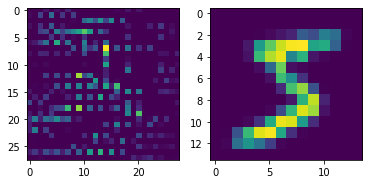

In [80]:
out=autoencoder.predict(feed[:5])
plt.subplot(1,2,1)
plt.imshow(out[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(feed[0].reshape(14,14))

In [81]:
autoencoder.fit(feed,X, epochs=n_epoch, batch_size=m, shuffle=True, verbose=2)

Epoch 1/25
235/235 - 58s - loss: 2964.4341
Epoch 2/25
235/235 - 57s - loss: 574.1174
Epoch 3/25
235/235 - 57s - loss: 378.2800
Epoch 4/25
235/235 - 57s - loss: 313.6636
Epoch 5/25
235/235 - 57s - loss: 270.2267
Epoch 6/25
235/235 - 57s - loss: 236.4022
Epoch 7/25
235/235 - 57s - loss: 220.5173
Epoch 8/25
235/235 - 57s - loss: 210.0678
Epoch 9/25
235/235 - 57s - loss: 202.2092
Epoch 10/25
235/235 - 57s - loss: 196.0414
Epoch 11/25
235/235 - 57s - loss: 191.1207
Epoch 12/25
235/235 - 57s - loss: 186.9029
Epoch 13/25
235/235 - 57s - loss: 182.9632
Epoch 14/25
235/235 - 57s - loss: 178.8963
Epoch 15/25
235/235 - 57s - loss: 174.9149
Epoch 16/25
235/235 - 57s - loss: 171.3615
Epoch 17/25
235/235 - 57s - loss: 167.8103
Epoch 18/25
235/235 - 57s - loss: 164.4273
Epoch 19/25
235/235 - 57s - loss: 161.3748
Epoch 20/25
235/235 - 57s - loss: 158.9906
Epoch 21/25
235/235 - 57s - loss: 156.9950
Epoch 22/25
235/235 - 57s - loss: 155.5607
Epoch 23/25
235/235 - 57s - loss: 154.1837
Epoch 24/25
235/235

In [86]:
out=autoencoder.predict(feed)

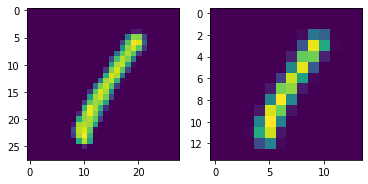

In [91]:
i=np.random.randint(0,10,1)
plt.subplot(1,2,1)
plt.imshow(out[i].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(feed[i].reshape(14,14))